> **Best algorithm comparison** \
> Comparison between TD3, SAC, and DSAC when controlling a LTI aircraft to track a sinusoidal pitch rate reference

# ⚙️ Set-up
Load required packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from helpers.paths import Path

sns.set()

Load a dataframe that contains the information from the algorithm's learning performance and a dataframe that contains the data from runing episodes with the learned agents

In [2]:
df_learn = pd.read_csv(Path.data/"best_algo_v2_learning.csv")
df_ep = pd.read_csv(Path.data/"best_algo_v2_episode.csv")

## Data checks

Number of unique learning for each algorithm

In [3]:
df_learn.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    30
SAC     30
TD3     30
dtype: int64

In [4]:
df_ep.groupby(["run", "algorithm"]).count().reset_index().value_counts("algorithm")

algorithm
DSAC    30
SAC     30
TD3     30
dtype: int64

## Data treatment

Define function that smooths data

In [5]:
step = 250

def make_smooth(_df, step=100, on=None, columns=None, group="run"):
    start = _df[on].min()
    stop = _df[on].max() + start
    info_list = []
    
    for run_name in df_learn[group].unique(): 
        # Get the name of the algorithm for the current run
        algorithm = _df.loc[_df[group]==run_name, "algorithm"].unique()[0]

        for t in np.arange(start, stop, step):
            mask = (_df[group]==run_name) & ((_df[on]>=t) & (_df[on]<t+step))
            run_slice = _df.loc[mask, columns]
            
            info = {"run": run_name, "step": t, "algorithm": algorithm}
            for column in columns:
                info[column] = run_slice[column].mean()
                
            info_list.append(info)
     
    return pd.DataFrame.from_records(info_list)

Smooth learning data

In [6]:
df_learn_smooth = make_smooth(df_learn, step=210, on="global_step", columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"])

# 👨🏽‍🏫 Learning performance

<AxesSubplot: xlabel='step', ylabel='rollout/ep_len_mean'>

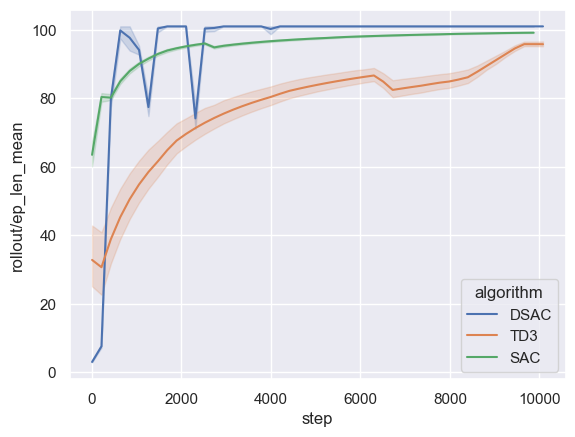

In [7]:
sns.lineplot(data=df_learn_smooth, x="step", y="rollout/ep_len_mean", hue="algorithm")